
# Wav2Vec2 İle Forced Alignment


In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

1.13.1+cu116
0.13.1+cu116
cuda


## Genel bakış

Proje de genel olarak şu adımları takip edeceğiz.

1. Ses dalga formundan çerçeve bazlı etiket olasılığını tahmin edeceğiz.
2. Olasılıkları içinde tutan bir matris elde edeceğiz.
3. Bu matrisi kullanarak en olası cümleyi oluşturacağız.

Akustik özellik çıkartmak için `torchaudio` ve `Wav2Vec2` kullanacağız.




## Hazırlık

Önce gerekli paketleri içeri aktaracağız ve veri setimizi hazırlayacağız.




In [2]:
# %matplotlib inline

from dataclasses import dataclass

import IPython
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)

SPEECH_FILE = torchaudio.utils.download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

  0%|          | 0.00/106k [00:00<?, ?B/s]

## Çerçeve bazlı etiket olasılığı oluşturalım.

İlk adım, her sesin etiket sınıfı olasılığını oluşturmaktır.
ASR için eğitilmiş bir WAV2VEC2 modeli kullanabiliriz.
`torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H`

``torchaudio`` kullanarak modele ulaşalım.


In [3]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()
with torch.inference_mode():
    waveform, _ = torchaudio.load(SPEECH_FILE)
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

### Görselleştirme



('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


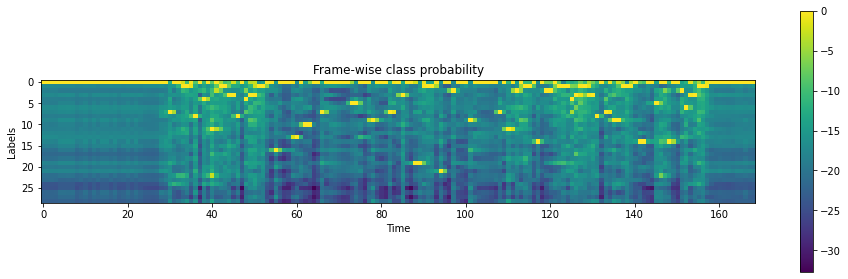

In [4]:
print(labels)
plt.imshow(emission.T)
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()

## Hizalama Olasılık Oluşturma (Trellis)

Emisyon matrisinden, daha sonra temsil eden Trellis üretiyoruz.
Transkript etiketlerinin olasılığı her zaman çerçevesinde meydana gelir.

Trellis zaman ekseni ve etiket ekseni ile 2D matrisdir. Etiket ekseni
hizaladığımız transkript'i temsil eder.


<img src="https://download.pytorch.org/torchaudio/tutorial-assets/ctc-forward.png">






In [5]:
transcript = "I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT"
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    # Trellis hem zaman ekseni hem de jetonlar için ekstra boyutlara sahiptir
    trellis = torch.empty((num_frame + 1, num_tokens + 1))
    trellis[0, 0] = 0
    trellis[1:, 0] = torch.cumsum(emission[:, 0], 0)
    trellis[0, -num_tokens:] = -float("inf")
    trellis[-num_tokens:, 0] = float("inf")

    for t in range(num_frame):
        trellis[t + 1, 1:] = torch.maximum(
            trellis[t, 1:] + emission[t, blank_id],
            trellis[t, :-1] + emission[t, tokens],
        )
    return trellis


trellis = get_trellis(emission, tokens)

[('I', 7), ('|', 1), ('H', 8), ('A', 4), ('D', 11), ('|', 1), ('T', 3), ('H', 8), ('A', 4), ('T', 3), ('|', 1), ('C', 16), ('U', 13), ('R', 10), ('I', 7), ('O', 5), ('S', 9), ('I', 7), ('T', 3), ('Y', 19), ('|', 1), ('B', 21), ('E', 2), ('S', 9), ('I', 7), ('D', 11), ('E', 2), ('|', 1), ('M', 14), ('E', 2), ('|', 1), ('A', 4), ('T', 3), ('|', 1), ('T', 3), ('H', 8), ('I', 7), ('S', 9), ('|', 1), ('M', 14), ('O', 5), ('M', 14), ('E', 2), ('N', 6), ('T', 3)]


### Görselleştirme



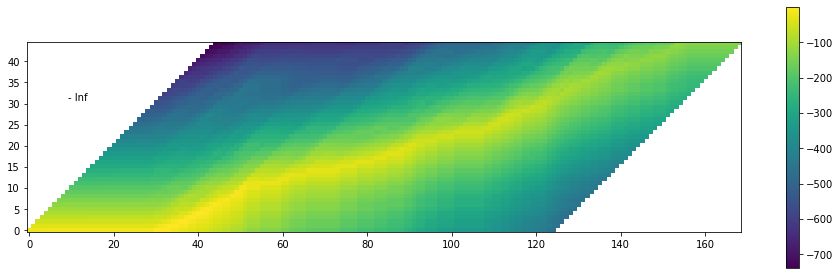

In [6]:
plt.imshow(trellis[1:, 1:].T, origin="lower")
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.show()

Yukarıdaki görselleştirmede, 
Matrisi çapraz olarak geçme olasılığının yüksek olduğunu görebiliriz.



## En olası yolu bulun (geri izleme)


In [7]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):

    j = trellis.size(1) - 1
    t_start = torch.argmax(trellis[:, j]).item()

    path = []
    for t in range(t_start, 0, -1):

        stayed = trellis[t - 1, j] + emission[t - 1, blank_id]

        changed = trellis[t - 1, j - 1] + emission[t - 1, tokens[j - 1]]

        prob = emission[t - 1, tokens[j - 1] if changed > stayed else 0].exp().item()

        path.append(Point(j - 1, t - 1, prob))

        if changed > stayed:
            j -= 1
            if j == 0:
                break
    else:
        raise ValueError("Failed to align")
    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

Point(token_index=0, time_index=30, score=0.9999842643737793)
Point(token_index=0, time_index=31, score=0.9846872687339783)
Point(token_index=0, time_index=32, score=0.999970555305481)
Point(token_index=0, time_index=33, score=0.15399768948554993)
Point(token_index=1, time_index=34, score=0.9999173879623413)
Point(token_index=1, time_index=35, score=0.6080352067947388)
Point(token_index=2, time_index=36, score=0.9997721314430237)
Point(token_index=2, time_index=37, score=0.9997126460075378)
Point(token_index=3, time_index=38, score=0.9999358654022217)
Point(token_index=3, time_index=39, score=0.9861578941345215)
Point(token_index=4, time_index=40, score=0.9238613247871399)
Point(token_index=4, time_index=41, score=0.9257358312606812)
Point(token_index=4, time_index=42, score=0.01566365733742714)
Point(token_index=5, time_index=43, score=0.9998378753662109)
Point(token_index=6, time_index=44, score=0.9988442659378052)
Point(token_index=6, time_index=45, score=0.10149640589952469)
Point(

### Görselleştirme



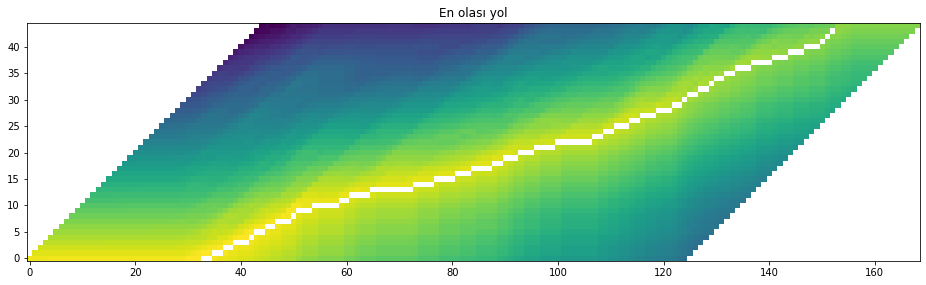

In [8]:
def plot_trellis_with_path(trellis, path):

    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path[1:, 1:].T, origin="lower")


plot_trellis_with_path(trellis, path)
plt.title("En olası yol")
plt.show()

İyi görünüyor. Şimdi bu yol aynı etiketler için tekrarlar içeriyor, bu nedenle
Orijinal transkript'e yakın hale getirmek için onları birleştirelim.

Birden fazla yol noktasını birleştirirken, sadece ortalamayı alırız




In [9]:
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

I	(0.78): [   30,    34)
|	(0.80): [   34,    36)
H	(1.00): [   36,    38)
A	(0.99): [   38,    40)
D	(0.62): [   40,    43)
|	(1.00): [   43,    44)
T	(0.55): [   44,    46)
H	(1.00): [   46,    48)
A	(0.37): [   48,    51)
T	(0.00): [   51,    52)
|	(1.00): [   52,    55)
C	(0.97): [   55,    60)
U	(1.00): [   60,    62)
R	(0.75): [   62,    66)
I	(0.88): [   66,    74)
O	(0.99): [   74,    78)
S	(1.00): [   78,    82)
I	(0.89): [   82,    85)
T	(0.78): [   85,    89)
Y	(0.70): [   89,    91)
|	(0.66): [   91,    94)
B	(1.00): [   94,    97)
E	(1.00): [   97,   101)
S	(1.00): [  101,   108)
I	(1.00): [  108,   110)
D	(0.93): [  110,   112)
E	(0.66): [  112,   115)
|	(1.00): [  115,   117)
M	(0.67): [  117,   120)
E	(0.67): [  120,   123)
|	(0.50): [  123,   125)
A	(0.98): [  125,   126)
T	(0.50): [  126,   128)
|	(0.51): [  128,   130)
T	(1.00): [  130,   131)
H	(1.00): [  131,   133)
I	(0.75): [  133,   135)
S	(0.36): [  135,   138)
|	(0.50): [  138,   142)
M	(1.00): [  142,   145)


### Görselleştirme



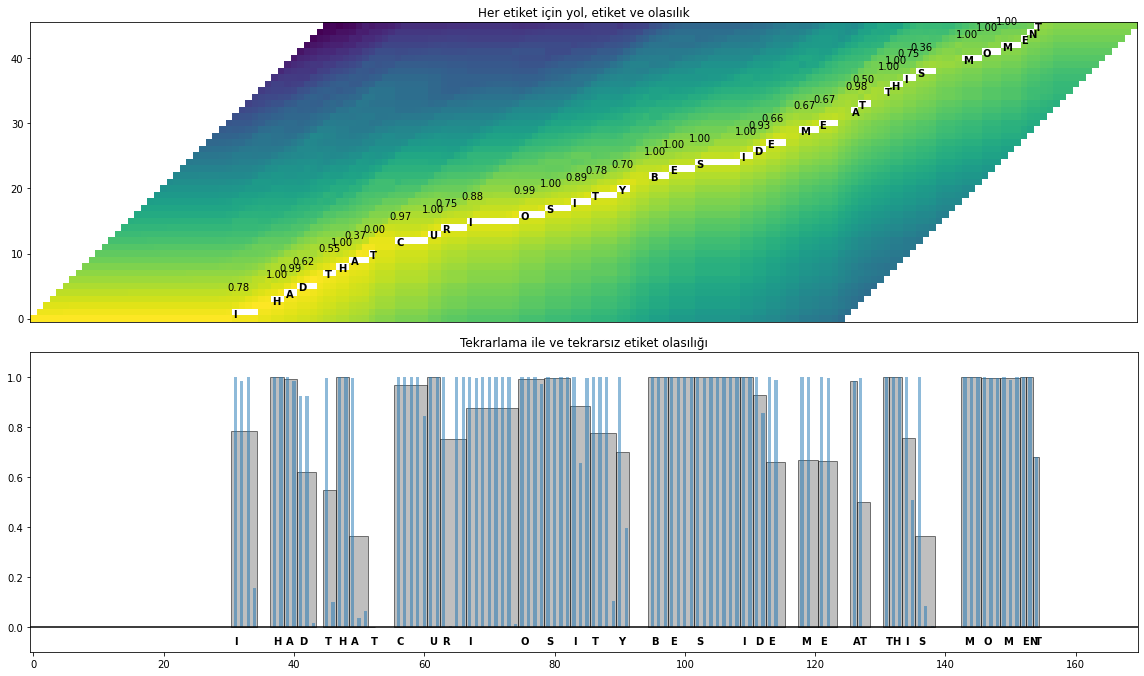

In [10]:
def plot_trellis_with_segments(trellis, segments, transcript):

    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))
    ax1.set_title("Her etiket için yol, etiket ve olasılık")
    ax1.imshow(trellis_with_path.T, origin="lower")
    ax1.set_xticks([])

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start + 0.7, i + 0.3), weight="bold")
            ax1.annotate(f"{seg.score:.2f}", (seg.start - 0.3, i + 4.3))

    ax2.set_title("Tekrarlama ile ve tekrarsız etiket olasılığı")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07), weight="bold")
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(-0.1, 1.1)


plot_trellis_with_segments(trellis, segments, transcript)
plt.tight_layout()
plt.show()

Şimdi kelimeleri birleştirelim. WAV2VEC2 modeli `` '|'``
Sınır kelimesi olarak, her bir olaydan önce segmentleri birleştiriyoruz
`|`.

Son olarak, orijinal sesi bölümlenmiş sese ayırıyoruz ve
Segmentasyonun doğru olup olmadığını görmek için onları dinleyin.



In [11]:
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

I	(0.78): [   30,    34)
HAD	(0.84): [   36,    43)
THAT	(0.52): [   44,    52)
CURIOSITY	(0.89): [   55,    91)
BESIDE	(0.94): [   94,   115)
ME	(0.67): [  117,   123)
AT	(0.66): [  125,   128)
THIS	(0.70): [  130,   138)
MOMENT	(0.97): [  142,   154)


### Görselleştirme



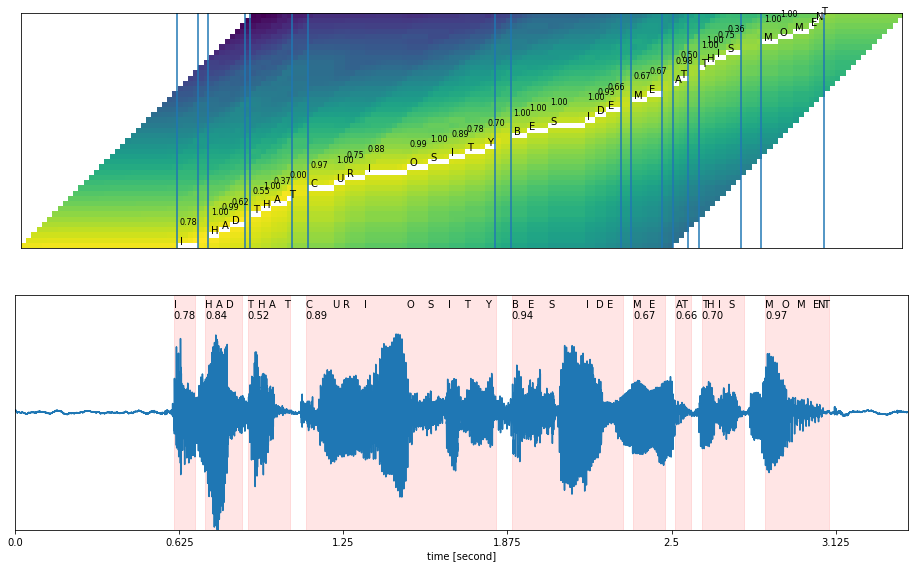

In [12]:
def plot_alignments(trellis, segments, word_segments, waveform):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))

    ax1.imshow(trellis_with_path[1:, 1:].T, origin="lower")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvline(word.start - 0.5)
        ax1.axvline(word.end - 0.5)

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i + 0.3))
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 4), fontsize=8)

    # The original waveform
    ratio = waveform.size(0) / (trellis.size(0) - 1)
    ax2.plot(waveform)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, alpha=0.1, color="red")
        ax2.annotate(f"{word.score:.2f}", (x0, 0.8))

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, 0.9))
    xticks = ax2.get_xticks()
    plt.xticks(xticks, xticks / bundle.sample_rate)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    ax2.set_ylim(-1.0, 1.0)
    ax2.set_xlim(0, waveform.size(-1))


plot_alignments(
    trellis,
    segments,
    word_segments,
    waveform[0],
)
plt.show()

In [13]:
def display_segment(i):
    ratio = waveform.size(1) / (trellis.size(0) - 1)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / bundle.sample_rate:.3f} - {x1 / bundle.sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=bundle.sample_rate)

In [14]:
# Generate the audio for each segment
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT


In [15]:
display_segment(0)

I (0.78): 0.604 - 0.684 sec


In [16]:
display_segment(1)

HAD (0.84): 0.724 - 0.865 sec


In [17]:
display_segment(2)

THAT (0.52): 0.885 - 1.046 sec


In [18]:
display_segment(3)

CURIOSITY (0.89): 1.107 - 1.831 sec


In [19]:
display_segment(4)

BESIDE (0.94): 1.891 - 2.314 sec


In [20]:
display_segment(5)

ME (0.67): 2.354 - 2.474 sec


In [21]:
display_segment(6)

AT (0.66): 2.515 - 2.575 sec


In [22]:
display_segment(7)

THIS (0.70): 2.615 - 2.776 sec


In [23]:
display_segment(8)

MOMENT (0.97): 2.857 - 3.098 sec
